<a href="https://colab.research.google.com/github/danieljai/CIND820-AndyLee/blob/main/AndyLee_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 4: Preload setup

Basic setup so results can utilize the full width of the screen.

In [1]:
%config IPCompleter.greedy=True
import pandas as pd

pd.set_option('display.max_colwidth', 200)
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100

# Step 5: Import Dataset

The hydrated file is stored in a Google Drive, and using the follow code will mount Google Drive onto Colaboratory.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

df = pd.read_csv("/content/drive/My Drive/__CIND 820 - Data Analytics Project/3-data/Book1-fastsave.csv")

# Step 6. Data Cleaning and Manipulation

## Readjust attribute datatype

For `retweet_id`, `in_reply_to_status_id`, `in_reply_to_user_id`
- Convert `null` values to 0
- Convert attribute as int64

In [4]:
df.retweet_id = df[df['retweet_id'].notnull()].retweet_id.astype('int64') 

In [5]:
df.retweet_id = df.retweet_id.fillna(0).astype('int64')
df.in_reply_to_status_id = df.in_reply_to_status_id.fillna(0).astype('int64')
df.in_reply_to_user_id = df.in_reply_to_user_id.fillna(0).astype('int64')

## Misc. cleaning up to reduce noise when conducting sentimental analysis
1. remove \n
2. remove URL
3. remove user referrals
4. remove hashtags

In [6]:
df['modified_text'] = df.text.str.replace(r'\n', '')
df['modified_text'] = df.modified_text.str.replace(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '')
df['modified_text'] = df.modified_text.str.replace(r'\B@\w+', '')
df['modified_text'] = df.modified_text.str.replace(r'\B#\w+', '')

## Splitting Dataframes (originals and retweets)

The collection includes both original tweets and retweets. Since retweets mirrors the original tweet by someone else other than the author, we don't need to run sentimental analysis on the retweet as it would have been run on the original tweet, therefore we can split original tweets and retweets into two dataframes to avoid wasting resources.


- Original tweets: `dfOriginals`
- Retweets: `dfRetweets` cons





In [7]:
dfOriginals = df[df.retweet_id == 0]
dfRetweets = df[df.retweet_id != 0]

## Preview data after cleaning and manipulation

Original Tweet dataframe datatypes

In [8]:
# https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/user-object
dfOriginals.dtypes

coordinates                    object
created_at                     object
hashtags                       object
media                          object
urls                           object
favorite_count                  int64
id                              int64
in_reply_to_screen_name        object
in_reply_to_status_id           int64
in_reply_to_user_id             int64
lang                           object
place                          object
possibly_sensitive             object
retweet_count                   int64
retweet_id                      int64
retweet_screen_name            object
source                         object
text                           object
tweet_url                      object
user_created_at                object
user_screen_name               object
user_default_profile_image       bool
user_description               object
user_favourites_count           int64
user_followers_count            int64
user_friends_count              int64
user_listed_

Two samples of the original tweet dataframe.

In [9]:
dfOriginals.sample(2)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,retweet_count,retweet_id,retweet_screen_name,source,text,tweet_url,user_created_at,user_screen_name,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,modified_text
167713,NaN,Tue Mar 31 10:15:13 +0000 2020,NaN,NaN,NaN,1,1244931245680799746,MLouisaE,1244908908986187776,2284836942,en,NaN,NaN,0,0,NaN,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","@MLouisaE @DavidNdii @Udadisi Eti ""Corona Times"". Nifty!",https://twitter.com/mungaikihanya/status/1244931245680799746,Wed May 26 08:27:11 +0000 2010,mungaikihanya,False,I am who I am https://t.co/FnHz0ho1mZ,1101,9466,9,20,"Nairobi, Kenya",Mungai Kihanya,mungaikihanya,34864,NaN,http://www.figures.co.ke,False,"Eti ""Corona Times"". Nifty!"
608857,NaN,Tue Mar 31 21:46:24 +0000 2020,WaqarZaka,NaN,http://www.tenup.io,0,1245105186776981505,NaN,0,0,en,NaN,False,0,0,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>","Because of Corona, Italian Bank Opens Bitcoin Trading to 1.2 Million during LockDown, @ImranKhanPTI we need to listen #WaqarZaka who developed https://t.co/JI9BTeOnLO which we can use to trade with the world legally without PAYPAL or paying a heavy fee.",https://twitter.com/HamaadK11436172/status/1245105186776981505,Sat Mar 02 15:17:32 +0000 2019,HamaadK11436172,True,Entrepreneur\nTrader\nStocks\nForex.,0,2,10,0,NaN,Hamaad Khan,HamaadK11436172,7,NaN,NaN,False,"Because of Corona, Italian Bank Opens Bitcoin Trading to 1.2 Million during LockDown, we need to listen who developed which we can use to trade with the world legally without PAYPAL or paying a heavy fee."


## Step 5: Guessing language

Since our sentiment analysis focuses on only English tweets, we will install a `langdetect` library to help filter out tweets that are not English.

In [10]:
#https://pypi.org/project/langdetect/
!pip install langdetect
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0



     |████████████████████████████████| 983kB 4.2MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=3f423d6657fe400363dfa4fc06b7d66f7f838f848968febd285ee07c3587e240
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


Function to test whether tweet is English with error handling.

In [11]:
#https://stackoverflow.com/questions/60930935/exclude-non-english-rows-in-pandas

def is_en(txt):
    try:
        return detect(txt)=='en'
    except:
        return False

Passing as the `is_en()` as first-class function; returning a boolean value as a attribute `guessed_language`.

In [12]:
dfOriginals['guessed_language'] = dfOriginals.modified_text.apply(is_en)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


My filtering out non-English tweets, we remove noise induced to the sentimental analysis which will affect the sentimental score.

In [13]:
print("There are " + str(len(dfOriginals)) + " tweets in total, and " + str(sum(dfOriginals.guessed_language)) + " detects as English.")
print("Percentage of tweets that are in English: " + str(round((sum(dfOriginals.guessed_language) / len(dfOriginals)) * 100, 4)) + "%")


There are 245389 tweets in total, and 232816 detects as English.
Percentage of tweets that are in English: 94.8763%


# Step 7. Sentiment Analysis

To conduct Seitment Analysis, we begin by importing the NLTK library.

In [14]:
import nltk
from nltk.sentiment.util import *
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
nltk.download('punkt')
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Applying Sentiment Analysis function

We apply the polarity score function and store results on a new attribute `sentimentscore`.



In [15]:
dfOriginals['sentimentscore'] = dfOriginals.text.apply(sid.polarity_scores)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


A quick sample preview of the text and its sentiment score.

In [16]:
dfOriginals.sample(10)[['modified_text','sentimentscore']]

,modified_text,sentimentscore
506110,"""Spitting out"". So what? Wondering why the famous journalist couple has not come out to defend them.Please be reminded that this simple misdeed of spitting out might be lethal, if any one of those 'spitting out' turns out to be a covid-19 victim.","{'neg': 0.045, 'neu': 0.905, 'pos': 0.05, 'compound': 0.0516}"
680321,Hope all this corona shit gets handled ASAP,"{'neg': 0.267, 'neu': 0.519, 'pos': 0.215, 'compound': -0.1779}"
96465,Useful medicine for fight against Corona Virus - Thymol (50 gram) + Camphor (30 gram) + Mint (50 gram) [all in solid form] put in a bottle and wait for mixup.Put some drops on hanky and smell it at least 10 time. Definitely it kill Corona viruses. Pls test it.,"{'neg': 0.129, 'neu': 0.722, 'pos': 0.15, 'compound': -0.2023}"
579618,"Kanika kapoor spread Corona virus in INDIA, she transferred corona virus in thousand people's in INDIA, Must be CBI inquiry she infected many many Our MP, MLA, and business man also, but DALAL MEDIA quite, because she not a Muslims if she were Muslims she also became jihadi,,","{'neg': 0.044, 'neu': 0.956, 'pos': 0.0, 'compound': -0.2732}"
594990,‘After thinking long and hard’,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
55817,All those who coming to save these corona terrorists should be arrested. This moron Mir Zafar should be put behind bar first,"{'neg': 0.269, 'neu': 0.648, 'pos': 0.083, 'compound': -0.802}"
389131,Minister's once a week shopping suggestion 'is not official guidance',"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
777825,The very final chapter of demon slayer is delayed due to Corona.... NOOOOOO!!!!!,"{'neg': 0.118, 'neu': 0.882, 'pos': 0.0, 'compound': -0.471}"
286957,Exactly. By the way SHAH sahab kahan hain aaj kal.,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
627306,LMAO! You're not along!,"{'neg': 0.0, 'neu': 0.434, 'pos': 0.566, 'compound': 0.7365}"


The `SentimentIntensityAnalyzer()` returns a dictionary of scores negative, neutral, positive, and compound. Compound is the normalization of negative, neutral, and positive values.


How compound is calculated? https://stackoverflow.com/questions/40325980/how-is-the-vader-compound-polarity-score-calculated-in-python-nltk

Next, we expand the score, which is currently as dictionary, into their own attributes for better data manipulation--especially the compound attribute.

In [17]:
dfOriginalSScore = pd.json_normalize(dfOriginals.sentimentscore)
dfOriginalSScore['original_index'] = dfOriginals.index
dfOriginalSScore = dfOriginalSScore.set_index('original_index')

In [18]:
dfOriginals = dfOriginals.merge(dfOriginalSScore, left_index=True, right_index=True)

In [19]:
dfOriginals.sample(10)[['modified_text','compound']]

,modified_text,compound
356655,"GOODBYE ABSURD!A module that opened my mind but Corona really ruined my vibe! Online learning isn't for me, but I'm keeping positive 😂",0.2250
557405,"In currency CORONA situation how Pakistan is planning to earn money or after this crisis? there is no product except this digital Gold which is suggesting, let him put crypto mining farm in KPK using Hydropower or tell us why it is not feasible?",-0.8144
603536,"Meet Pedro Corona, proud father of Class of 2022 President Derrick Corona and alum Samantha Corona. Thank you for keeping us safe during these difficult times, Officer. We appreciate your service",0.8271
714812,"'Amid Corona, good wildlife news,' says Rajasthan CM Gehlot as Sariska tigress gives birth",0.4404
245827,LolBeen saying this since forever now,0.4215
791977,APRIL FOOLS!! Corona isn’t real😂😂,-0.6723
605317,"go get one, corona isn’t getting you far",0.0000
400221,Dem go isolate some of Las Las.... Without corona meddling sef.... Cos the moment you mess (ya so) and house scatter.... 😈😈Guy! Isolation straight 🙃🙃🙃,-0.6588
751009,"The National for March 22, 2020 ...",0.0000
482077,"while all countries now are facing shortages of supplies and staff to treat those infected w corona, the challenges facing the Palestinian territories are exacerbated by more than half a century of Israeli military occupation and its hampering of development",-0.2023


Splitting sentiment score into 5 classes of equal 0.4 parts.
- -1 to -0.6 for extra negative
- -0.6 to -0.2 for slight negative
- 0.2 to 0.2 for neutral
- 0.2 to 0.6 for slight positive
- 0.6 to 1 for extra positive

In [20]:
dfOriginals['sentiment_class'] = pd.cut(dfOriginals['compound'], bins=[-1, -.6, -.2, 0.2, .6, 1], right=True, labels=['x_neg', 's_neg', 'neu', 's_pos','x_pos'])

In [21]:
dfOriginals.sample(10)[['modified_text','compound','sentiment_class']]

,modified_text,compound,sentiment_class
758181,Bro of this what they gata do to test me for Covid19 cheapus ya put me sleep cuz me staying wake for this shit,-0.6428,x_neg
794425,I’m actually in the midst of writing my Corona Chronicles. So I got you. Don’t steal that name.,-0.4939,s_neg
455545,This corona virus is scary. Cause if it enters slums and suburbs how do you want an infected person to self isolate in a room of 7-10 persons in a face me I face you yard.,-0.7845,x_neg
299141,So a few months into the corona crisis and this is what you came up with? Still trying to influence the media instead of actually doing something useful... Wow! Thanks! 🤦‍♂️,0.4912,s_pos
249574,Sir i am student of law from mlsu Udaipur and i want to ask to u that we are having semester system and from this corona we are not having and what will for out exam,0.0772,neu
782062,"😂😂😂Now Check them, Both will be get Corona positive",0.5574,s_pos
736632,"Oh no I am so relieved now that you have pointed out that medical errors killed 250,00 every year in the US compare with novel corona virus PANDEMIC w/ no cure &amp; mortality rate of 1-3% that is 10 times more contagious than the flu &amp; spread over 180 countries in three months! Yea!",-0.8997,x_neg
700604,MSNBC is disgustingly promoting trump’s campaign now. Fox is going to do what they always do promote false information to get trump re-elected. Why in the world MSNBC cover this political rally from the White House? Mind bugling!,0.1260,neu
514244,Fuck a bitch named corona 🖕🏾🦠,-0.8074,x_neg
796821,Virus se Bachne ke Upay,0.0000,neu


Getting the total count for each sentiment class.

In [22]:
dfOriginals.sentiment_class.value_counts()

neu      82447
s_pos    48833
s_neg    47398
x_neg    35876
x_pos    30835
Name: sentiment_class, dtype: int64

Creating a more relaxed system of sentiment classification, compound scores of -1 to -0.1 = negative 
-0.1 to 0.1  = neutral
0.1 to 1 = positive.

reference:
Deo, G. S., Mishra, A., Jalaluddin, Z. M., & Mahamuni, C. V. (2020, September). Predictive Analysis of Resource Usage Data in Academic Libraries using the VADER Sentiment Algorithm. In 2020 12th International Conference on Computational Intelligence and Communication Networks (CICN) (pp. 221-228). IEEE.

https://www.researchgate.net/profile/Gouri_Deo/publication/342988903_Predictive_Analysis_of_Resource_Usage_Data_in_Academic_Libraries_using_the_VADER_Sentiment_Algorithm/links/5f1085a6a6fdcc3ed70bcf20/Predictive-Analysis-of-Resource-Usage-Data-in-Academic-Libraries-using-the-VADER-Sentiment-Algorithm.pdf



In [23]:
dfOriginals['sentiment_class_relaxed'] = pd.cut(dfOriginals['compound'], bins=[-1, -.1, 0.1, 1], right=True, labels=['neg', 'neu', 'pos'])
dfOriginals.sentiment_class_relaxed.value_counts()

neg    89699
pos    85606
neu    70084
Name: sentiment_class_relaxed, dtype: int64

- impact factor of a tweet 

# Step 8. Basic Analysis

Observing the correlation between variables.

In [24]:
dfOriginals[['favorite_count','retweet_count','user_followers_count','compound','user_statuses_count']].corr()

,favorite_count,retweet_count,user_followers_count,compound,user_statuses_count
favorite_count,1.000000,0.908576,0.165683,-0.001289,0.015366
retweet_count,0.908576,1.000000,0.090025,-0.003297,0.015991
user_followers_count,0.165683,0.090025,1.000000,0.003237,0.116452
compound,-0.001289,-0.003297,0.003237,1.000000,-0.016042
user_statuses_count,0.015366,0.015991,0.116452,-0.016042,1.000000


In [25]:
dfOriginals[['favorite_count','retweet_count','user_followers_count','compound','user_statuses_count','user_verified']].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,favorite_count,retweet_count,user_followers_count,compound,user_statuses_count
count,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000
mean,9.52971,2.70475,9251.20519,-0.01442,27468.30799
std,384.21091,122.27732,250678.23602,0.48520,75560.36124
min,0.00000,0.00000,0.00000,-0.99590,1.00000
25%,0.00000,0.00000,64.00000,-0.40190,1156.00000
50%,0.00000,0.00000,331.00000,0.00000,6344.00000
75%,1.00000,0.00000,1307.00000,0.38180,24616.00000
max,108137.00000,35137.00000,62855265.00000,0.99190,4472178.00000


# Step 9. Build Classification

## Split Train and Test set

In [26]:
dfOriginals[['favorite_count','retweet_count','user_followers_count','compound']]

,favorite_count,retweet_count,user_followers_count,compound
3,0,0,54,0.0129
4,0,0,73,0.3400
6,0,0,55,0.4404
7,0,0,79,0.6369
12,0,0,36,0.8885
...,...,...,...,...
799126,0,0,36,-0.9267
799127,1,0,8,0.0000
799128,1,0,5,0.2023
799130,3,0,441,-0.5106


In [27]:
from sklearn import preprocessing
from sklearn import linear_model

trainSet=dfOriginals.sample(frac=0.8,random_state=200)
testSet=dfOriginals.drop(trainSet.index)

# X_train = preprocessing.scale(trainSet[['retweet_count','user_followers_count','compound','user_statuses_count','user_verified']])
# X_train = preprocessing.scale(trainSet[['user_followers_count','compound','user_statuses_count','user_verified']])
X_train = (trainSet[['retweet_count','user_followers_count','compound']])
Y_train = trainSet['favorite_count']
reg = linear_model.LinearRegression()

reg.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
# from sklearn import tree
# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X_train, Y_train)


In [29]:
# clf.predict(testSet[['retweet_count','user_followers_count','compound','user_statuses_count','user_verified',]]) #- testSet['favorite_count']
plot_1_Y = reg.predict(testSet[['retweet_count','user_followers_count','compound']]) # predicted as Y
plot_1_X = testSet['favorite_count'].reset_index()  # actual as X
df_plot_1 = pd.concat([plot_1_X,pd.DataFrame(plot_1_Y)],axis=1)
df_plot_1.columns = ['index','actual', 'predicted']
df_plot_1

,index,actual,predicted
0,3,0,1.334603
1,12,0,2.639196
2,28,1,1.471820
3,52,0,1.825821
4,77,1,2.497649
...,...,...,...
49073,799102,1,1.357766
49074,799123,0,1.311873
49075,799126,0,-0.070743
49076,799127,1,1.308692


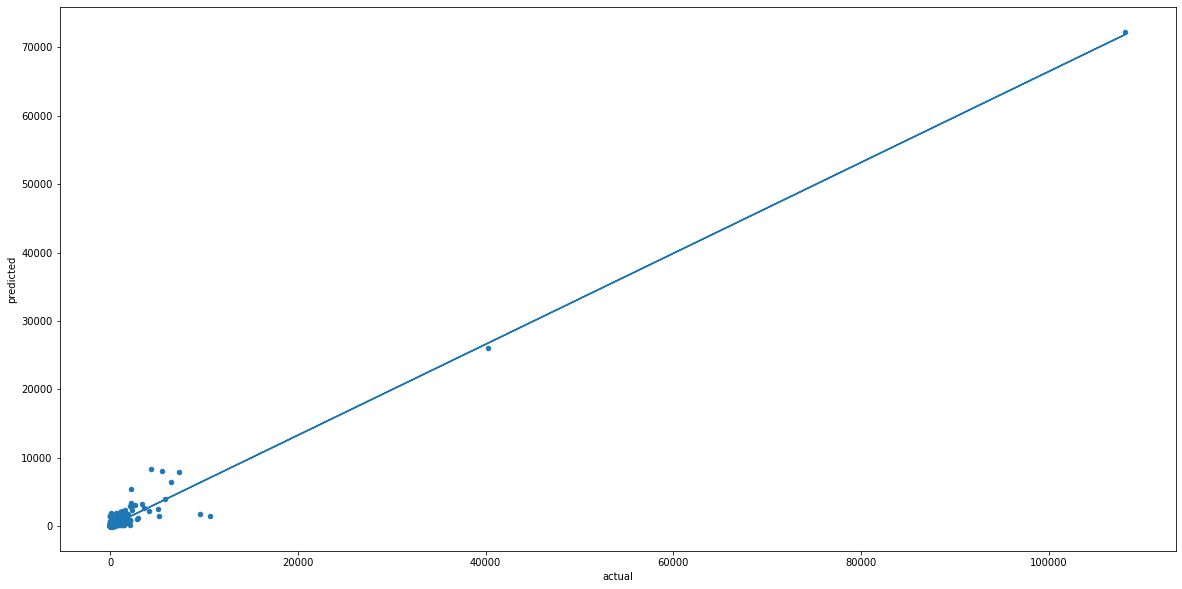

In [30]:
from numpy.polynomial.polynomial import polyfit

plot_1 = df_plot_1.plot.scatter(x='actual',y='predicted',figsize=(20,10))
b, m = polyfit(df_plot_1.actual, df_plot_1.predicted, 1)

plot_1.plot(df_plot_1.actual, b + m * df_plot_1.actual, '-')

# df_plot_1.plot(x='actual',y='predicted', ax=plot_1)

Mean Square Error

In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(df_plot_1.actual, df_plot_1.predicted)
print("MSE: " + str(mse))
print("RMSE: " + str(sqrt(mse)))
# sqrt(mse)

MSE: 36005.685772655306
RMSE: 189.7516423450804


## Attempt 2

- Groupby user_screen_name
- calculate the mean sentiment score
- see whether there are any correlation between number of followers and number of favourite tweets against the mean sentimental score (check SD)

explain properly an understanding of why introducing new feature

In [33]:
dfOriginals.groupby('user_screen_name').size().reset_index(name='counts').sort_values(by='counts', ascending=False)

,user_screen_name,counts
27508,ELister_social,666
79905,SattarSarki1,382
133777,iHeartFun1,185
27433,EG24NEWS,181
142347,kailashscienti1,179
...,...,...
68494,Patterico,1
68495,PattheOldBat,1
68496,PattiClifford10,1
68498,PattiMurin,1
